In [1]:
#Importação das bibliotecas e ferramentas

import pandas as pd
import numpy as np
import re
import nltk
import spacy
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords 
from unidecode import unidecode
from gensim.models import Word2Vec, doc2vec

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Importação dos Modelos
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb


# Desabilitar avisos
import warnings
warnings.filterwarnings('ignore')

In [2]:
#!pip install spacy
#!python -m spacy download pt_core_news_lg

In [3]:
#nltk.download('stopwords')
#nltk.download('punkt')
stopwords = set(stopwords.words('portuguese'))
stemmer = SnowballStemmer('portuguese')
nlp = spacy.load("pt_core_news_lg")

In [4]:
#Carregando o dataset
data = pd.read_csv('./Dados/train/Train3Classes.csv')

## Etapa 1 - Preparação dos Dados e Verificação de Consistência

In [5]:
#Informações do dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95000 entries, 0 to 94999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          95000 non-null  int64 
 1   tweet_text  95000 non-null  object
 2   tweet_date  95000 non-null  object
 3   sentiment   95000 non-null  int64 
 4   query_used  95000 non-null  object
dtypes: int64(2), object(3)
memory usage: 3.6+ MB


In [6]:
#Verificando itens duplicados
data.duplicated().value_counts()

False    95000
dtype: int64

In [7]:
#Verificando itens nulos
data.isnull().value_counts()

id     tweet_text  tweet_date  sentiment  query_used
False  False       False       False      False         95000
dtype: int64

In [8]:
#Dropando as colunas que não agregam ao modelo
data = data.drop(['id', 'tweet_date', 'query_used'], axis=1)

In [9]:
#Visualização Inicial
data.head(5)

,tweet_text,sentiment
0,Rio elege maior bancada policial de sua histór...,2
1,fiquei tão triste quando eu vi o preço da câme...,0
2,"Para Theresa May, seu plano para o Brexit é a ...",2
3,caralho eu quero proteger a danielly em um pot...,0
4,@SiCaetano_ viva o caos :),1


## Etapa 2 - Análise Exploratória dos Dados

Valores de cada Target
0    31696
1    31678
2    31626
Name: sentiment, dtype: int64


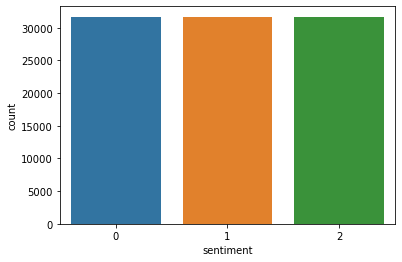

In [10]:
# Gráfico de balanceamento da base de dados
sns.countplot(data['sentiment']);
media = data['sentiment'].value_counts()
print('Valores de cada Target')
print(media)

Conforme demostrado através dos valores e gráfico as classes são bem balanceadas.

## Etapa 3 - Pré-processamento e transformações

In [11]:
# Pipeline - Text Preprocessing

def preprocessing(string):
    # Remove Acccent
    string = unidecode(string)
    ###
    # Removes users, http addresses and special characters
    string = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", string)
    # Remove Numbers
    string = re.sub(r'\d', '', string)
    ###
    # Lowercase Words
    string = string.lower()
    ###
    # Word Tokenize
    words = word_tokenize(string)
    ###
    # Remove Stopwords
    filtered_words = []
    for w in words:
        if w not in stopwords:
            filtered_words.append(w)
   
    
    return filtered_words


In [12]:
def stemming(string):
    # Stemming Words
    stem_words = []
    for w in string:
        s_words = stemmer.stem(w)
        stem_words.append(s_words)
    stem_words = ' '.join(stem_words)   
    return stem_words

In [13]:
def lemmantizer(string):
    # Lemmantize Words
    lemma_words = []
    doc = nlp(string)
    for token in doc:
        s_words = token.lemma_
        lemma_words.append(s_words)
    lemma_words = ' '.join(lemma_words)
    return lemma_words


In [14]:
data["filtered_words"] = data['tweet_text'].apply(lambda x: preprocessing(x))
data['join_words'] = data['filtered_words'].apply(lambda x: ' '.join(x))

In [15]:
# Optei por fazer o Stemmer e o Lemmantizer separados para a avaliação
data['stemmer'] = data['filtered_words'].apply(lambda x: stemming(x))
data['lemmantizer'] = data['join_words'].apply(lambda x: lemmantizer(x))

In [16]:
data.head()

,tweet_text,sentiment,filtered_words,join_words,stemmer,lemmantizer
0,Rio elege maior bancada policial de sua histór...,2,"[rio, elege, maior, bancada, policial, historia]",rio elege maior bancada policial historia,rio eleg maior banc policial histor,rir eleger maior bancada policial historiar
1,fiquei tão triste quando eu vi o preço da câme...,0,"[fiquei, tao, triste, vi, preco, camera]",fiquei tao triste vi preco camera,fiqu tao trist vi prec cam,ficar tao triste vir preco camera
2,"Para Theresa May, seu plano para o Brexit é a ...",2,"[theresa, may, plano, brexit, unica, opcao]",theresa may plano brexit unica opcao,theres may plan brexit unic opca,theresa may planar brexit unica opcao
3,caralho eu quero proteger a danielly em um pot...,0,"[caralho, quero, proteger, danielly, pote, tad...",caralho quero proteger danielly pote tadinhaa,caralh quer proteg danielly pot tadinha,caralho querer proteger danielly pote tadinhaa
4,@SiCaetano_ viva o caos :),1,"[viva, caos]",viva caos,viv caos,vivo caos


In [17]:
# Fracionando o dataframe para a execução dos testes
data_sample = data.sample(frac=0.1, replace=False)

Valores de cada Target
0    3185
1    3163
2    3152
Name: sentiment, dtype: int64


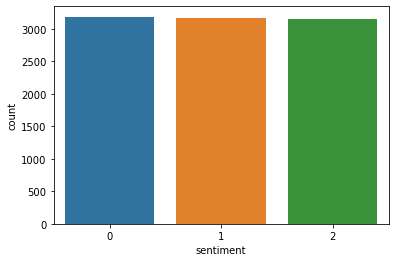

In [18]:
# Gráfico de balanceamento da base de dados da amostra
sns.countplot(data_sample['sentiment']);
media = data_sample['sentiment'].value_counts()
print('Valores de cada Target')
print(media)

In [19]:
# X e y com Stemmer
X = data_sample['stemmer']
y = data_sample['sentiment']

# X e y com Lemmantizer
X1 = data_sample['lemmantizer']
y1 = data_sample['sentiment']

In [20]:
#Separando em train e test para ambos processamentos (Stemmer e Lemmantizer)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.3, 
                                                    random_state = 42,
                                                    stratify=y)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, 
                                                        y1, 
                                                        test_size = 0.3, 
                                                        random_state = 42,
                                                        stratify=y)

In [21]:
#Lista de Modelos de Machine Learning
random_seed = 42

list_models = [
{'model_name': 'Logistic Regression',
 'estimator' : LogisticRegression(random_state = random_seed, solver = 'lbfgs')},
{'model_name': 'Decision Tree',
 'estimator' : DecisionTreeClassifier(random_state = random_seed)},
{'model_name': 'Random Forest',
 'estimator' : RandomForestClassifier(random_state = random_seed)}, 
{'model_name': 'NBMultinomial',
 'estimator' : MultinomialNB(alpha=1.0,fit_prior=True)},
{'model_name': 'NBBernoulli',
 'estimator' : BernoulliNB(alpha=1.0,fit_prior=True)},
]

In [22]:
# Função de Métricas para os Modelos
def test_models_plot_roc_auc_curve(model_list, col_model_name, col_model, X_train, X_test, y_train, y_test):
    for mdl in model_list:
        model = mdl[col_model]
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        print("Model      : %s" % mdl[col_model_name])
        print("Accuracy   : %0.4f " %  accuracy_score(y_test, y_predict))
        print("Precision  : %0.4f " % precision_score(y_test, y_predict, average='weighted'))
        print("Recall     : %0.4f " % recall_score(y_test, y_predict, average='weighted'))
        print("F1 - Score : %0.4f " % f1_score(y_test, y_predict, average='weighted'))
        print("======================")

### CountVectorizer

In [23]:
#Instanciando o Modelo
cv = CountVectorizer()

In [24]:
#Normalizando os dados
X_train_cv = cv.fit_transform(X_train).toarray()
X_test_cv = cv.transform(X_test).toarray()

X1_train_cv = cv.fit_transform(X1_train).toarray()
X1_test_cv = cv.transform(X1_test).toarray()

In [25]:
#Testando todos os modelos com Stemmer
test_models_plot_roc_auc_curve(list_models,
                               "model_name",
                               "estimator",
                               X_train_cv,
                               X_test_cv,
                               y_train,
                               y_test)

Model      : Logistic Regression
Accuracy   : 0.7512 
Precision  : 0.7537 
Recall     : 0.7512 
F1 - Score : 0.7522 
Model      : Decision Tree
Accuracy   : 0.6804 
Precision  : 0.6792 
Recall     : 0.6804 
F1 - Score : 0.6769 
Model      : Random Forest
Accuracy   : 0.7074 
Precision  : 0.7112 
Recall     : 0.7074 
F1 - Score : 0.7041 
Model      : NBMultinomial
Accuracy   : 0.7509 
Precision  : 0.7496 
Recall     : 0.7509 
F1 - Score : 0.7496 
Model      : NBBernoulli
Accuracy   : 0.7305 
Precision  : 0.7463 
Recall     : 0.7305 
F1 - Score : 0.7293 


In [26]:
#Testando todos os modelos com Lemmantizer
test_models_plot_roc_auc_curve(list_models,
                               "model_name",
                               "estimator",
                               X1_train_cv,
                               X1_test_cv,
                               y1_train,
                               y1_test)

Model      : Logistic Regression
Accuracy   : 0.7435 
Precision  : 0.7482 
Recall     : 0.7435 
F1 - Score : 0.7453 
Model      : Decision Tree
Accuracy   : 0.6625 
Precision  : 0.6649 
Recall     : 0.6625 
F1 - Score : 0.6612 
Model      : Random Forest
Accuracy   : 0.7105 
Precision  : 0.7193 
Recall     : 0.7105 
F1 - Score : 0.7106 
Model      : NBMultinomial
Accuracy   : 0.7453 
Precision  : 0.7454 
Recall     : 0.7453 
F1 - Score : 0.7447 
Model      : NBBernoulli
Accuracy   : 0.7242 
Precision  : 0.7454 
Recall     : 0.7242 
F1 - Score : 0.7228 


Na execução do CountVectorizer entre o Stemmer e o Lemmantizer, comparando ambos com o melhor modelo (Logistic Regression), o processamento entre ambos é bem semelhante.

### TF-IDF

In [27]:
#Instanciando o Modelo
tfidf = TfidfVectorizer(use_idf = True, max_features=8000)

In [28]:
#Normalizando os dados
X_train_tfidf = tfidf.fit_transform(X_train).todense()
X_test_tfidf  = tfidf.transform(X_test).todense()

X1_train_tfidf = tfidf.fit_transform(X1_train).todense()
X1_test_tfidf  = tfidf.transform(X1_test).todense()

In [29]:
#Testando todos os modelos com Stemmer
test_models_plot_roc_auc_curve(list_models,
                               "model_name",
                               "estimator",
                               X_train_tfidf,
                               X_test_tfidf,
                               y_train,
                               y_test)

Model      : Logistic Regression
Accuracy   : 0.7547 
Precision  : 0.7531 
Recall     : 0.7547 
F1 - Score : 0.7535 
Model      : Decision Tree
Accuracy   : 0.6775 
Precision  : 0.6765 
Recall     : 0.6775 
F1 - Score : 0.6744 
Model      : Random Forest
Accuracy   : 0.7302 
Precision  : 0.7283 
Recall     : 0.7302 
F1 - Score : 0.7281 
Model      : NBMultinomial
Accuracy   : 0.7449 
Precision  : 0.7446 
Recall     : 0.7449 
F1 - Score : 0.7440 
Model      : NBBernoulli
Accuracy   : 0.7323 
Precision  : 0.7456 
Recall     : 0.7323 
F1 - Score : 0.7314 


In [30]:
#Testando todos os modelos com Lemmantizer
test_models_plot_roc_auc_curve(list_models,
                               "model_name",
                               "estimator",
                               X1_train_tfidf,
                               X1_test_tfidf,
                               y1_train,
                               y1_test)

Model      : Logistic Regression
Accuracy   : 0.7512 
Precision  : 0.7481 
Recall     : 0.7512 
F1 - Score : 0.7491 
Model      : Decision Tree
Accuracy   : 0.6818 
Precision  : 0.6832 
Recall     : 0.6818 
F1 - Score : 0.6807 
Model      : Random Forest
Accuracy   : 0.7263 
Precision  : 0.7267 
Recall     : 0.7263 
F1 - Score : 0.7252 
Model      : NBMultinomial
Accuracy   : 0.7393 
Precision  : 0.7419 
Recall     : 0.7393 
F1 - Score : 0.7388 
Model      : NBBernoulli
Accuracy   : 0.7260 
Precision  : 0.7436 
Recall     : 0.7260 
F1 - Score : 0.7250 


Na execução do TF-IDF entre o Stemmer e o Lemmantizer, comparando ambos com o melhor modelo (Logistic Regression), novamente o processamento com o Stemmer teve uma leve vantagem, demonstrando que é desnecessario seguir com o Lemmantizer.

### WORD2VEC

In [31]:
#Lista de Modelos de Machine Learning
random_seed = 42

list_models_w = [
{'model_name': 'Logistic Regression',
 'estimator' : LogisticRegression(random_state = random_seed, solver = 'lbfgs')},
{'model_name': 'Decision Tree',
 'estimator' : DecisionTreeClassifier(random_state = random_seed)},
{'model_name': 'Random Forest',
 'estimator' : RandomForestClassifier(random_state = random_seed)}, 
{'model_name': 'AdaBoost',
 'estimator' : AdaBoostClassifier(random_state = random_seed)},
{'model_name': 'XGBoost      ',
 'estimator' : XGBClassifier(eval_metric='mlogloss', random_state = random_seed)},
{'model_name': 'LightGBM     ',
 'estimator' : lgb.LGBMClassifier(random_state = random_seed)},
]

In [32]:
model = Word2Vec(sentences=X_train, vector_size=500, min_count=5, window=3)

In [33]:
X_train_w2v_m = [] # Treino com a média
X_train_w2v_s = [] # Treino com a soma
X_train_w2v_sn = [] # Treino com a soma normalizada


for phrase in X_train:
    vecs = []
    for word in phrase:
        if word in model.wv.index_to_key:
            vecs.append(model.wv.get_vector(word))
            
    if vecs:
        soma = np.sum(vecs, axis=0)
        media = soma/len(vecs)
        soma_normalizada = soma / np.linalg.norm(soma)
        
        X_train_w2v_m.append(media)
        X_train_w2v_s.append(soma)
        X_train_w2v_sn.append(soma_normalizada)
        
    else:
        X_train_w2v_m.append(np.zeros(model.vector_size))
        X_train_w2v_s.append(np.zeros(model.vector_size))
        X_train_w2v_sn.append(np.zeros(model.vector_size))
    
    
X_train_w2v_m = np.array(X_train_w2v_m)
X_train_w2v_s = np.array(X_train_w2v_s)
X_train_w2v_sn = np.array(X_train_w2v_sn)

In [34]:
X_test_w2v_m = [] # Teste com a média
X_test_w2v_s = [] # Teste com a soma
X_test_w2v_sn = [] # Teste com a soma normalizada

for phrase in X_test:
    vecs = []
    for word in phrase:
        if word in model.wv.index_to_key:
            vecs.append(model.wv.get_vector(word))
            
    if vecs:
        soma = np.sum(vecs, axis=0)
        media = soma/len(vecs)
        soma_normalizada = soma / np.linalg.norm(soma)
        
        X_test_w2v_m.append(media)
        X_test_w2v_s.append(soma)
        X_test_w2v_sn.append(soma_normalizada)
        
    else:
        X_test_w2v_m.append(np.zeros(model.vector_size))
        X_test_w2v_s.append(np.zeros(model.vector_size))
        X_test_w2v_sn.append(np.zeros(model.vector_size))
    
    
X_test_w2v_m = np.array(X_test_w2v_m)
X_test_w2v_s = np.array(X_test_w2v_s)
X_test_w2v_sn = np.array(X_test_w2v_sn)

In [35]:
#Testando todos os modelos com a média
test_models_plot_roc_auc_curve(list_models_w,
                               "model_name",
                               "estimator",
                               X_train_w2v_m,
                               X_test_w2v_m,
                               y_train,
                               y_test)

Model      : Logistic Regression
Accuracy   : 0.4474 
Precision  : 0.4427 
Recall     : 0.4474 
F1 - Score : 0.4379 
Model      : Decision Tree
Accuracy   : 0.4782 
Precision  : 0.4788 
Recall     : 0.4782 
F1 - Score : 0.4784 
Model      : Random Forest
Accuracy   : 0.5625 
Precision  : 0.5539 
Recall     : 0.5625 
F1 - Score : 0.5568 
Model      : AdaBoost
Accuracy   : 0.5389 
Precision  : 0.5288 
Recall     : 0.5389 
F1 - Score : 0.5302 
Model      : XGBoost      
Accuracy   : 0.5498 
Precision  : 0.5404 
Recall     : 0.5498 
F1 - Score : 0.5429 
Model      : LightGBM     
Accuracy   : 0.5656 
Precision  : 0.5564 
Recall     : 0.5656 
F1 - Score : 0.5588 


In [36]:
#Testando todos os modelos com a soma
test_models_plot_roc_auc_curve(list_models_w,
                               "model_name",
                               "estimator",
                               X_train_w2v_s,
                               X_test_w2v_s,
                               y_train,
                               y_test)

Model      : Logistic Regression
Accuracy   : 0.5442 
Precision  : 0.5277 
Recall     : 0.5442 
F1 - Score : 0.5273 
Model      : Decision Tree
Accuracy   : 0.5053 
Precision  : 0.5070 
Recall     : 0.5053 
F1 - Score : 0.5061 
Model      : Random Forest
Accuracy   : 0.5961 
Precision  : 0.5853 
Recall     : 0.5961 
F1 - Score : 0.5884 
Model      : AdaBoost
Accuracy   : 0.5614 
Precision  : 0.5459 
Recall     : 0.5614 
F1 - Score : 0.5496 
Model      : XGBoost      
Accuracy   : 0.5863 
Precision  : 0.5762 
Recall     : 0.5863 
F1 - Score : 0.5797 
Model      : LightGBM     
Accuracy   : 0.5870 
Precision  : 0.5760 
Recall     : 0.5870 
F1 - Score : 0.5796 


In [37]:
#Testando todos os modelos com a soma normalizada
test_models_plot_roc_auc_curve(list_models_w,
                               "model_name",
                               "estimator",
                               X_train_w2v_sn,
                               X_test_w2v_sn,
                               y_train,
                               y_test)

Model      : Logistic Regression
Accuracy   : 0.5175 
Precision  : 0.5160 
Recall     : 0.5175 
F1 - Score : 0.4993 
Model      : Decision Tree
Accuracy   : 0.4716 
Precision  : 0.4726 
Recall     : 0.4716 
F1 - Score : 0.4720 
Model      : Random Forest
Accuracy   : 0.5600 
Precision  : 0.5515 
Recall     : 0.5600 
F1 - Score : 0.5542 
Model      : AdaBoost
Accuracy   : 0.5270 
Precision  : 0.5129 
Recall     : 0.5270 
F1 - Score : 0.5164 
Model      : XGBoost      
Accuracy   : 0.5670 
Precision  : 0.5572 
Recall     : 0.5670 
F1 - Score : 0.5595 
Model      : LightGBM     
Accuracy   : 0.5747 
Precision  : 0.5664 
Recall     : 0.5747 
F1 - Score : 0.5685 


### Doc2Vec

In [38]:
def read_corpus(list_sentences, tokens_only=False):
    if tokens_only:
        # For test data, just return sentences
        return list_sentences
    else:
        # For training data, add tags
        lista = []
        for i, line in enumerate(list_sentences):
            lista.append(doc2vec.TaggedDocument(line, [i]))

        return lista

In [39]:
train_corpus = read_corpus(X_train)
test_corpus = read_corpus(X_test, tokens_only=True)

In [40]:
model = doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=20)

In [41]:
model.build_vocab(train_corpus)

In [42]:
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [43]:
X_train_d2v = []

for phrase in X_train:
    phrase = phrase.split()
    vecs = []
    vecs.append(model.infer_vector(phrase))

    X_train_d2v.append(vecs)
    
X_train_d2v = np.array(X_train_d2v)

In [44]:
X_test_d2v = []

for phrase in X_test:
    phrase = phrase.split()
    vecs = []
    vecs.append(model.infer_vector(phrase))

    X_test_d2v.append(vecs)
    
X_test_d2v = np.array(X_test_d2v)

In [45]:
X_train_d2v = X_train_d2v[:,0,:]
X_test_d2v = X_test_d2v[:,0,:]

In [46]:
#Testando todos os modelos
test_models_plot_roc_auc_curve(list_models_w,
                               "model_name",
                               "estimator",
                               X_train_d2v,
                               X_test_d2v,
                               y_train,
                               y_test)

Model      : Logistic Regression
Accuracy   : 0.3825 
Precision  : 0.3982 
Recall     : 0.3825 
F1 - Score : 0.3668 
Model      : Decision Tree
Accuracy   : 0.4084 
Precision  : 0.4082 
Recall     : 0.4084 
F1 - Score : 0.4083 
Model      : Random Forest
Accuracy   : 0.4218 
Precision  : 0.4337 
Recall     : 0.4218 
F1 - Score : 0.4211 
Model      : AdaBoost
Accuracy   : 0.3940 
Precision  : 0.4077 
Recall     : 0.3940 
F1 - Score : 0.3898 
Model      : XGBoost      
Accuracy   : 0.4214 
Precision  : 0.4238 
Recall     : 0.4214 
F1 - Score : 0.4217 
Model      : LightGBM     
Accuracy   : 0.4330 
Precision  : 0.4375 
Recall     : 0.4330 
F1 - Score : 0.4325 


## Conclusão
Os melhores modelos com a melhor técnica inicial, são:

#### Técnica - TF-IDF

**Logistic Regression** - Accuracy - 0,7547 / F1 - Score - 0,7535  
**NBMultinomial** - Accuracy - 0,7449 / F1 - Score - 0,7440  


## Etapa 4 - Treinamento do Modelo

In [47]:
#Lista de Modelos de Machine Learning
random_seed = 42

best_models = [
{'model_name': 'Logistic Regression',
 'estimator' : LogisticRegression(random_state = random_seed, solver = 'lbfgs')},
{'model_name': 'NBMultinomial      ',
 'estimator' : MultinomialNB(alpha=1.0,fit_prior=True)},
]

Modelo               Accuracy  Desvio Padrão
Logistic Regression: 0.754586 (0.012497)
NBMultinomial      : 0.740752 (0.004237)


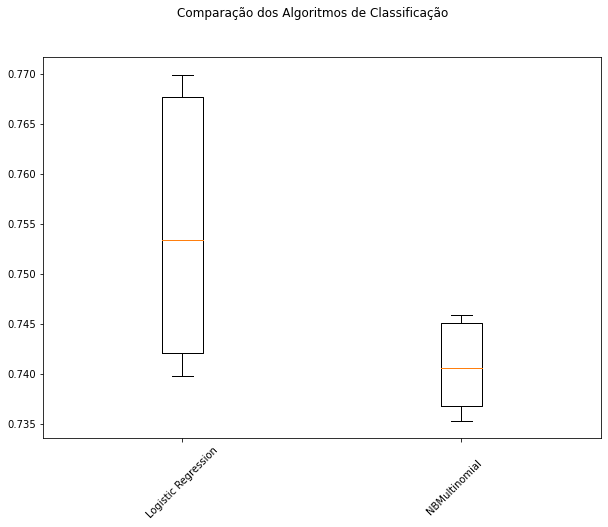

In [48]:
# Validação Cruzada com os 2 melhores resultados de Acuracia

num_folds = 5
seed = 42

resultados = []
nomes = []
count = 0

for mdl in best_models:
    model = mdl['estimator']
    kfold = StratifiedKFold(num_folds, True, random_state = seed)
    cv_results = cross_val_score(model, X_train_tfidf, y_train, cv = kfold, scoring = 'accuracy')
    resultados.append(cv_results)
    nomes.append(best_models[count]['model_name'])
    if count == 0:
        print('\033[1mModelo               Accuracy  Desvio Padrão\033[0m')
    msg = "%s: %f (%f)" % (best_models[count]['model_name'], cv_results.mean(), cv_results.std())
    print(msg)
    count += 1
    
    
# Boxplot para comparar os algoritmos
fig = plt.figure(figsize=(10, 7))
fig.suptitle('Comparação dos Algoritmos de Classificação')
ax = fig.add_subplot(111)
plt.boxplot(resultados)
ax.set_xticklabels(nomes, rotation = 45)
plt.show()

In [49]:
# LogisticRegression com os melhores parâmetros

num_folds = 5
seed = 42

# Separando os dados em folds
kfold = StratifiedKFold(num_folds, True, random_state = seed)

# Criando o modelo
modelo_lr = LogisticRegression(solver = 'newton-cg', 
                                penalty = 'l2', 
                                C = 1.0, 
                                random_state = 42)
# Cross Validation
resultado = cross_val_score(modelo_lr, X_train_tfidf, y_train, cv = kfold, scoring = 'accuracy')

dt_res = resultado.mean() * 100

# Print do resultado
print("Accuracy: %.3f" % (resultado.mean() * 100))

Accuracy: 75.459


In [50]:
# MultinomialNB com os melhores parâmetros

num_folds = 5
seed = 42

# Separando os dados em folds
kfold = StratifiedKFold(num_folds, True, random_state = seed)

# Criando o modelo
modelo_mnb = MultinomialNB(fit_prior = True,
                           alpha = 6)

# Cross Validation
resultado = cross_val_score(modelo_mnb, X_train_tfidf, y_train, cv = kfold, scoring = 'accuracy')

dt_res = resultado.mean() * 100

# Print do resultado
print("Accuracy: %.3f" % (resultado.mean() * 100))

Accuracy: 73.850


### Conclusão

O RandomizedSearchCV não agregou valor ao modelo, permanecendo como melhor modelo a Logistic Regression: 0,7547 em TF-IDF e com um custo computacional muito menor. 

## Etapa 5 - Finalização na base de Submissão

In [51]:
# Modelo escolhido LogisticRegression com TFIDF
model_LR = LogisticRegression(random_state = random_seed, solver = 'lbfgs')
model_LR.fit(X_train_tfidf, y_train)
y_predict = model_LR.predict(X_test_tfidf)
print("Model      : %s" % 'LogisticRegression')
print("Accuracy   : %0.4f " %  accuracy_score(y_test, y_predict))
print("Precision  : %0.4f " % precision_score(y_test, y_predict, average='weighted'))
print("Recall     : %0.4f " % recall_score(y_test, y_predict, average='weighted'))
print("F1 - Score : %0.4f " % f1_score(y_test, y_predict, average='weighted'))
print("======================")

Model      : LogisticRegression
Accuracy   : 0.7547 
Precision  : 0.7531 
Recall     : 0.7547 
F1 - Score : 0.7535 


In [70]:
#Carregando o dataset Submissão
data_sub = pd.read_csv('./Dados/subm/Subm3Classes.csv')

In [71]:
data_sub

,id,tweet_text,tweet_date,query_used
0,1046764676707753987,Apartamento Vila Mariana Praça Monteiro dos Sa...,Mon Oct 01 14:12:01 +0000 2018,:)
1,1047329264943751169,@FalleNCS @BrasilGameShow quero 1x1 de scout. ...,Wed Oct 03 03:35:29 +0000 2018,:)
2,1045443874947313665,mais uma analógica no correio à minha espera :...,Thu Sep 27 22:43:37 +0000 2018,:)
3,1040484298711814144,"Em festa de posse como presidente do STF, Toff...",Fri Sep 14 06:16:02 +0000 2018,folha
4,1045411876887306240,@thethiagor @jubsilva @GSCISA @GrupoMulheRIs A...,Thu Sep 27 20:36:28 +0000 2018,:)
...,...,...,...,...
4995,1049243861732794369,"Não é nada demais , apenas a verdade :) — Oh.....",Mon Oct 08 10:23:25 +0000 2018,:)
4996,1039334757690163201,Veja o que é #FATO ou #FAKE na entrevista de A...,Tue Sep 11 02:08:10 +0000 2018,#fato
4997,1049286902577356801,"@nattvieiira de quem???? queria ver, eu sai po...",Mon Oct 08 13:14:27 +0000 2018,:(
4998,1045349300744671232,ASSASSIN'S CREED ORIGINS: ENFRENTANDO OS IRMÃO...,Thu Sep 27 16:27:49 +0000 2018,:)


In [72]:
# Informações do dataset
data_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          5000 non-null   int64 
 1   tweet_text  5000 non-null   object
 2   tweet_date  5000 non-null   object
 3   query_used  5000 non-null   object
dtypes: int64(1), object(3)
memory usage: 156.4+ KB


In [73]:
#Verificando itens duplicados
data_sub.duplicated().value_counts()

False    5000
dtype: int64

In [74]:
#Verificando itens nulos
data_sub.isnull().value_counts()

id     tweet_text  tweet_date  query_used
False  False       False       False         5000
dtype: int64

In [75]:
#Dropando as colunas que não agregam ao modelo
data_sub = data_sub.drop(['tweet_date', 'query_used'], axis=1)

In [76]:
data_sub.head(5)

,id,tweet_text
0,1046764676707753987,Apartamento Vila Mariana Praça Monteiro dos Sa...
1,1047329264943751169,@FalleNCS @BrasilGameShow quero 1x1 de scout. ...
2,1045443874947313665,mais uma analógica no correio à minha espera :...
3,1040484298711814144,"Em festa de posse como presidente do STF, Toff..."
4,1045411876887306240,@thethiagor @jubsilva @GSCISA @GrupoMulheRIs A...


In [77]:
# Tratamentos no dataset
data_sub["filtered_words"] = data_sub['tweet_text'].apply(lambda x: preprocessing(x))
data_sub['join_words'] = data_sub['filtered_words'].apply(lambda x: ' '.join(x))
data_sub['stemmer'] = data_sub['filtered_words'].apply(lambda x: stemming(x))

In [78]:
data_sub

,id,tweet_text,filtered_words,join_words,stemmer
0,1046764676707753987,Apartamento Vila Mariana Praça Monteiro dos Sa...,"[apartamento, vila, mariana, praca, monteiro, ...",apartamento vila mariana praca monteiro santos...,apart vil marian prac monteir sant imud especi...
1,1047329264943751169,@FalleNCS @BrasilGameShow quero 1x1 de scout. ...,"[quero, x, scout, dizem, dou, muita, bala, cag...",quero x scout dizem dou muita bala cagada,quer x scout diz dou muit bal cag
2,1045443874947313665,mais uma analógica no correio à minha espera :...,"[analogica, correio, espera, d, so, falta, rec...",analogica correio espera d so falta receber du...,analog correi esper d so falt receb duas lent ...
3,1040484298711814144,"Em festa de posse como presidente do STF, Toff...","[festa, posse, presidente, stf, toffoli, canta...",festa posse presidente stf toffoli canta legia...,fest poss president stf toffol cant legia urban
4,1045411876887306240,@thethiagor @jubsilva @GSCISA @GrupoMulheRIs A...,"[flavia, tuiter, tambem]",flavia tuiter tambem,flav tuit tamb
...,...,...,...,...,...
4995,1049243861732794369,"Não é nada demais , apenas a verdade :) — Oh.....","[nao, nada, demais, apenas, verdade, oh, pront...",nao nada demais apenas verdade oh pronto obrig...,nao nad dem apen verdad oh pront obrigadaaaa
4996,1039334757690163201,Veja o que é #FATO ou #FAKE na entrevista de A...,"[veja, fato, fake, entrevista, anthony, garoti...",veja fato fake entrevista anthony garotinho rjtv,vej fat fak entrev anthony garotinh rjtv
4997,1049286902577356801,"@nattvieiira de quem???? queria ver, eu sai po...","[queria, ver, sai, causa, lucas]",queria ver sai causa lucas,quer ver sai caus luc
4998,1045349300744671232,ASSASSIN'S CREED ORIGINS: ENFRENTANDO OS IRMÃO...,"[assassin, s, creed, origins, enfrentando, irm...",assassin s creed origins enfrentando irmaos ze...,assassin s creed origins enfrent irma ze ruel via


In [79]:
# Criando o array para predição
X1 = data_sub['stemmer']

In [80]:
# Instanciando o modelo
X_sub = tfidf.fit_transform(X1).todense()

In [81]:
# Predizendo novos dados
sub_pred = model_LR.predict(X_sub)

In [82]:
# Adicionando a coluna predita
data_sub["sentiment_predict"] = sub_pred

In [83]:
data_sub

,id,tweet_text,filtered_words,join_words,stemmer,sentiment_predict
0,1046764676707753987,Apartamento Vila Mariana Praça Monteiro dos Sa...,"[apartamento, vila, mariana, praca, monteiro, ...",apartamento vila mariana praca monteiro santos...,apart vil marian prac monteir sant imud especi...,1
1,1047329264943751169,@FalleNCS @BrasilGameShow quero 1x1 de scout. ...,"[quero, x, scout, dizem, dou, muita, bala, cag...",quero x scout dizem dou muita bala cagada,quer x scout diz dou muit bal cag,1
2,1045443874947313665,mais uma analógica no correio à minha espera :...,"[analogica, correio, espera, d, so, falta, rec...",analogica correio espera d so falta receber du...,analog correi esper d so falt receb duas lent ...,2
3,1040484298711814144,"Em festa de posse como presidente do STF, Toff...","[festa, posse, presidente, stf, toffoli, canta...",festa posse presidente stf toffoli canta legia...,fest poss president stf toffol cant legia urban,2
4,1045411876887306240,@thethiagor @jubsilva @GSCISA @GrupoMulheRIs A...,"[flavia, tuiter, tambem]",flavia tuiter tambem,flav tuit tamb,2
...,...,...,...,...,...,...
4995,1049243861732794369,"Não é nada demais , apenas a verdade :) — Oh.....","[nao, nada, demais, apenas, verdade, oh, pront...",nao nada demais apenas verdade oh pronto obrig...,nao nad dem apen verdad oh pront obrigadaaaa,2
4996,1039334757690163201,Veja o que é #FATO ou #FAKE na entrevista de A...,"[veja, fato, fake, entrevista, anthony, garoti...",veja fato fake entrevista anthony garotinho rjtv,vej fat fak entrev anthony garotinh rjtv,1
4997,1049286902577356801,"@nattvieiira de quem???? queria ver, eu sai po...","[queria, ver, sai, causa, lucas]",queria ver sai causa lucas,quer ver sai caus luc,1
4998,1045349300744671232,ASSASSIN'S CREED ORIGINS: ENFRENTANDO OS IRMÃO...,"[assassin, s, creed, origins, enfrentando, irm...",assassin s creed origins enfrentando irmaos ze...,assassin s creed origins enfrent irma ze ruel via,1


In [88]:
# Gerando csv com as predições
data_sub[['id', 'sentiment_predict']].to_csv('Ricardo_Passador_nlp_degree.csv', index=False)

## Conclusões Finais



O estudo com NLP é muito interessante, embora dificil de lidar com as ferramentas, pois a maior dificuldade é com a generalização da escrita em Português (abreviações, simbologias, girias, etc) e as ferramentas especificas para a lingua portuguesa.
Sendo como mais dificil, na minha opinião, o EDA do projeto.
As ferramentas de Bag of Words (CountVectorizer e TF-IDF) bem como WORD2Vec e DOC2Vec, são muito interessantes, pois fazem a mágica da conversão textual para numerica, de forma que o computador possa interpretar, e isso realmente achei muito interessante.
Os modelos são pacotes "padrão" que simplesmente recebem os dados e fazem a matemática acontecer, mas também fiquei muito surpreso com a assertividade, uma vez que os dados recebidos não são tão pautados em regras. Então a generalização dos modelos me surpreendeu.
Enfim NLP é um assunto de muita profundidade, estudos e desenvolvimentos, pois é um campo muito rico para o vislumbre de insights através de expressões escritas.